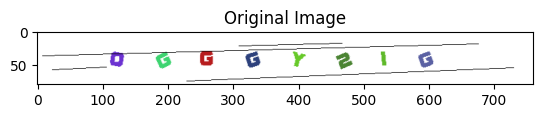

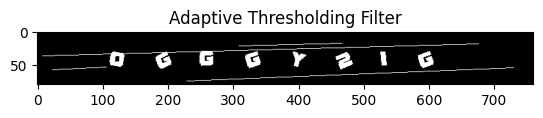

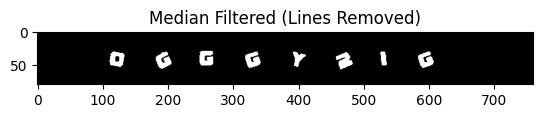

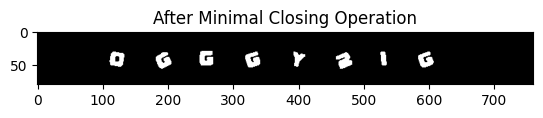

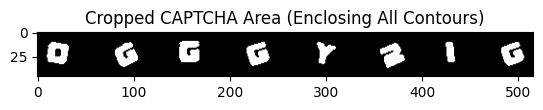

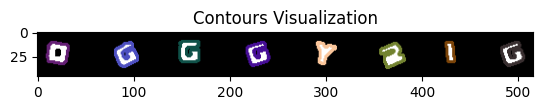

Grouped_boxes:  8


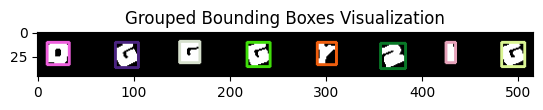

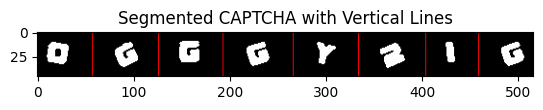

(10, 11, 23, 23)
(46, 23, 3)


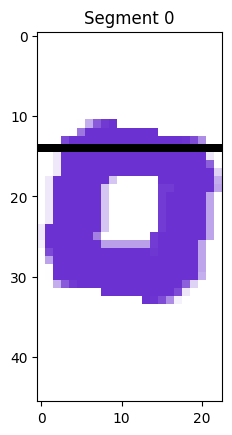

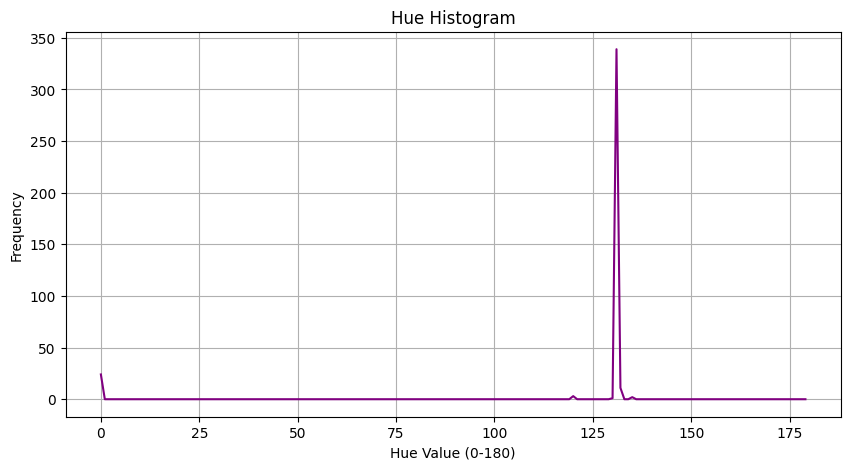

Detected Peaks: [131]
(81, 11, 24, 26)
(46, 24, 3)


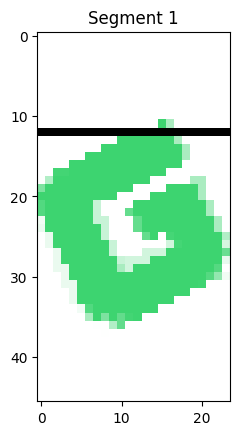

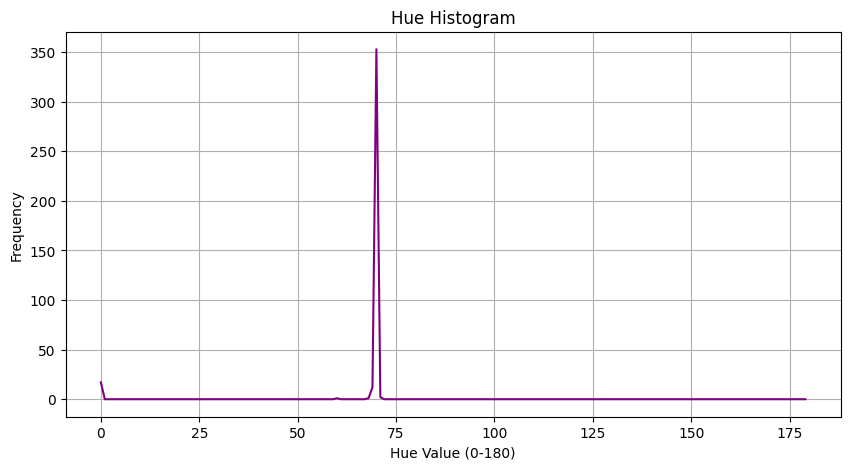

Detected Peaks: [70]
(148, 10, 21, 22)
(46, 21, 3)


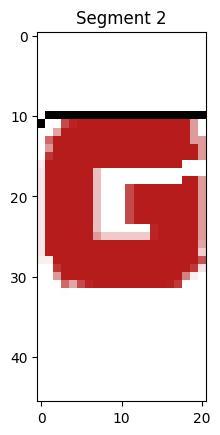

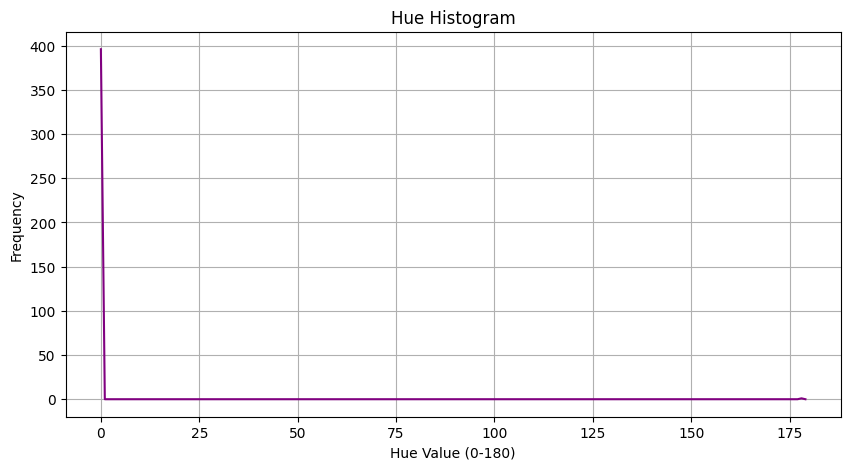

Detected Peaks: []
(218, 11, 24, 25)
(46, 24, 3)


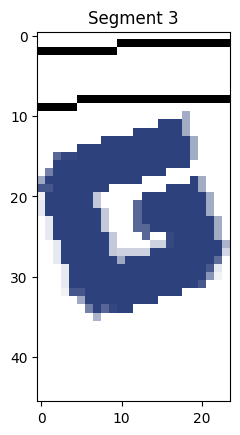

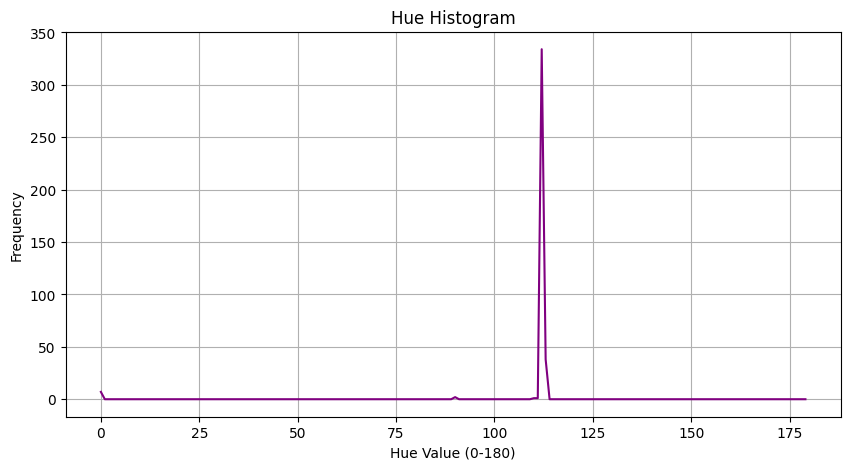

Detected Peaks: [112]
(291, 11, 20, 23)
(46, 20, 3)


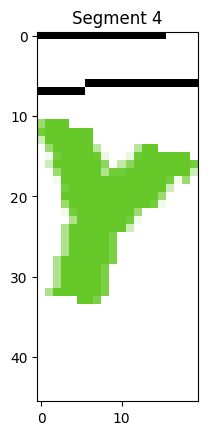

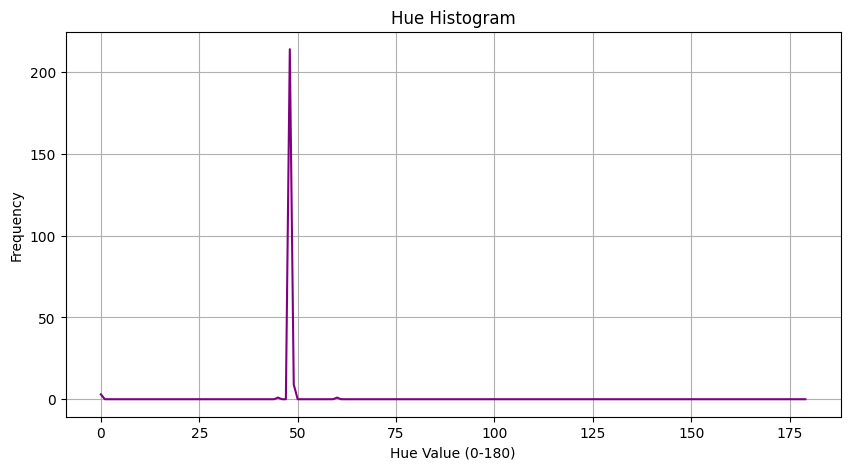

Detected Peaks: [48]
(357, 12, 26, 26)
(46, 26, 3)


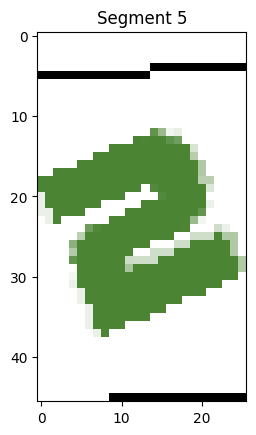

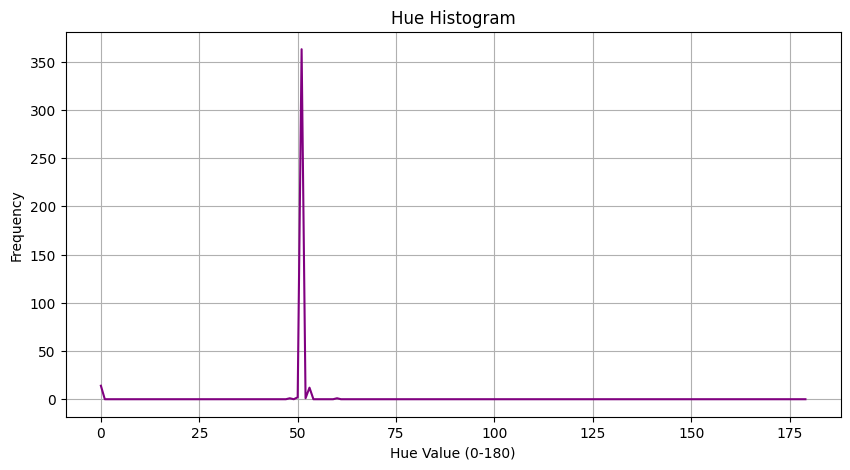

Detected Peaks: [51]
(425, 11, 10, 21)
(46, 10, 3)


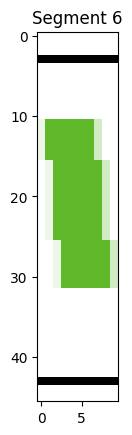

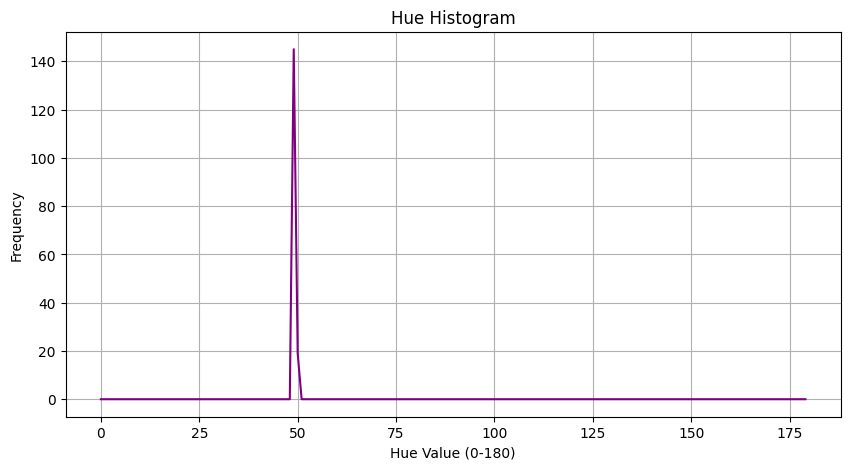

Detected Peaks: [49]
(483, 11, 24, 25)
(46, 24, 3)


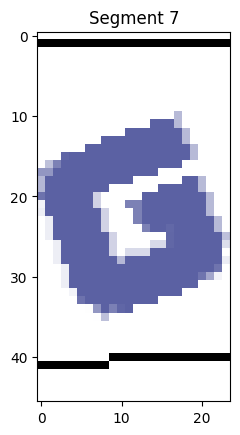

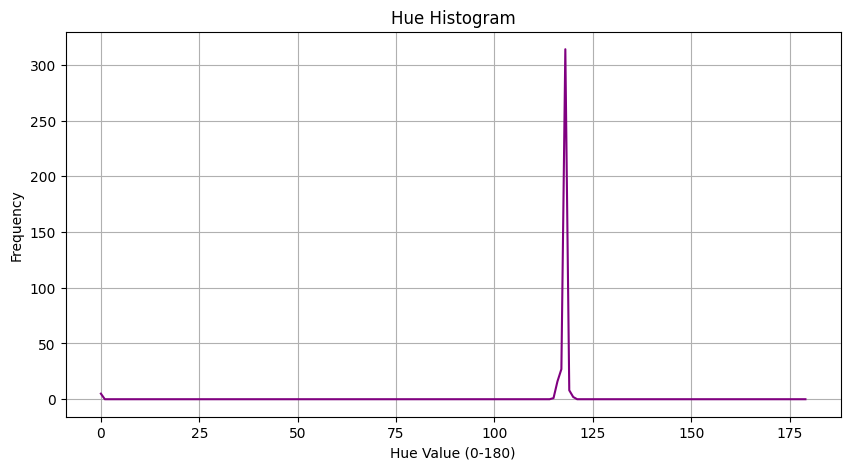

Detected Peaks: [118]


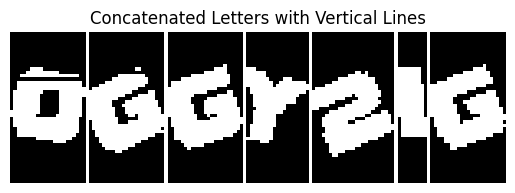

In [49]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

show_images = True

image_path = "train/0gggy2ig-0.png" #"train/zn927m-0.png"#"train/2jefvnxe-0.png" #"train/zn927m-0.png"
image = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hist_adjusted = cv2.equalizeHist(grayscale)
adaptive_thresh = cv2.adaptiveThreshold(hist_adjusted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)
if show_images:
    plt.imshow(adaptive_thresh, cmap='gray')
    plt.title('Adaptive Thresholding Filter')
    plt.show()

median_filtered = cv2.medianBlur(adaptive_thresh, 3)
if show_images:
    plt.imshow(median_filtered, cmap='gray')
    plt.title('Median Filtered (Lines Removed)')
    plt.show()

morphology_kernel = np.ones((3, 3), np.uint8)
opened_img = cv2.morphologyEx(median_filtered, cv2.MORPH_OPEN, morphology_kernel, iterations=1)
if show_images:
    plt.imshow(opened_img, cmap='gray')
    plt.title('After Minimal Closing Operation')
    plt.show()

opened_img_contours, _ = cv2.findContours(opened_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not opened_img_contours:
    print("No contours found in the image.")
    exit()

all_points = np.vstack(opened_img_contours).squeeze()
all_x, all_y = all_points[:, 0], all_points[:, 1]

pad = 10
height, width = opened_img.shape
x_min, x_max = max(0, min(all_x) - pad), min(width, max(all_x) + pad)
y_min, y_max = max(0, min(all_y) - pad), min(height, max(all_y) + pad)

x_max_crop = x_max

captcha_area = median_filtered[y_min:y_max, x_min:x_max]
captcha_area_colored = image[y_min:y_max, x_min:x_max]

if show_images:
    plt.imshow(captcha_area, cmap='gray')
    plt.title('Cropped CAPTCHA Area (Enclosing All Contours)')
    plt.show()
    
captcha_contours, _ = cv2.findContours(captcha_area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

### Visualization
contour_visualization = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)
for i, contour in enumerate(captcha_contours):
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    cv2.drawContours(contour_visualization, [contour], -1, color, 2)

if show_images:
    plt.imshow(contour_visualization)
    plt.title('Contours Visualization')
    plt.show()
###

bounding_boxes_coords = sorted([cv2.boundingRect(contour) for contour in captcha_contours], key=lambda x: x[0])

grouped_boxes = []
current_group = bounding_boxes_coords[0]

for box in bounding_boxes_coords[1:]:
    x, y, w, h = box
    prev_x, prev_y, prev_w, prev_h = current_group
    overlap_width = min(prev_x + prev_w, x + w) - max(prev_x, x)

    if overlap_width > 0 and (overlap_width >= 0.6 * w or overlap_width >= 0.6 * prev_w):
        current_group = (
            min(prev_x, x),
            min(prev_y, y),
            max(prev_x + prev_w, x + w) - min(prev_x, x),
            max(prev_y + prev_h, y + h) - min(prev_y, y)
        )
    else:
        grouped_boxes.append(current_group)
        current_group = box

grouped_boxes.append(current_group)
print("Grouped_boxes: ", len(grouped_boxes))

### Visualize grouped bounding boxes
grouped_visualization = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)
for group in grouped_boxes:
    x, y, w, h = group
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    cv2.rectangle(grouped_visualization, (x, y), (x + w, y + h), color, 2)

if show_images:
    plt.imshow(grouped_visualization)
    plt.title('Grouped Bounding Boxes Visualization')
    plt.show()
###

### Draw vertical lines
segmented_image = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)
for i in range(1, len(grouped_boxes)):
    prev_x = grouped_boxes[i - 1][0] + grouped_boxes[i - 1][2]
    curr_x = grouped_boxes[i][0]
    line_x = (prev_x + curr_x) // 2
    cv2.line(segmented_image, (line_x, 0), (line_x, captcha_area.shape[0]), (255, 0, 0), 1)

if show_images:
    plt.imshow(segmented_image)
    plt.title('Segmented CAPTCHA with Vertical Lines')
    plt.show()
###


grouped_boxes.sort(key=lambda x: x[0])

detected_letters = []

# Find hues
for i in range(len(grouped_boxes)):
    x_box, y_box, w_box, h_box = grouped_boxes[i]
    segment = captcha_area_colored[:, x_box:min(x_box + w_box, x_max_crop)]
    print(grouped_boxes[i])
    print(segment.shape)

    if segment is None or segment.size == 0 or segment.shape[1] == 0:
        print(f"Skipping empty segment {i}")
        continue

    if show_images:    
        plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
        plt.title(f'Segment {i}')
        plt.show()

    hsv_segment = cv2.cvtColor(segment, cv2.COLOR_BGR2HSV)
    hue, saturation, value = cv2.split(hsv_segment)

    segment_mask = captcha_area[:, x_box:x_box + w_box]
    segment_mask_resized = cv2.resize(segment_mask, (hue.shape[1], hue.shape[0])) 
    segment_mask_binary = cv2.threshold(segment_mask_resized, 127, 255, cv2.THRESH_BINARY)[1]

    hist = cv2.calcHist([hue], [0], segment_mask_binary, [180], [0, 180]).flatten()

    if show_images:
        plt.figure(figsize=(10, 5))
        plt.plot(hist, color='purple')
        plt.title("Hue Histogram")
        plt.xlabel("Hue Value (0-180)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()


    peak_threshold = 0.3 * max(hist)
    peaks = np.sort(np.where(hist > peak_threshold)[0])
    peaks = peaks[peaks > 0]

    combined_peaks = [peaks[0]] if len(peaks) > 0 else []

    for peak in peaks[1:]:
        if abs(peak - combined_peaks[-1]) >= 5:
            combined_peaks.append(peak)

    peaks = np.array(combined_peaks)
    print("Detected Peaks:", peaks)

    segment_contours = []

    for peak in peaks:
        lower_bound = np.array([max(peak - 2, 0)], dtype=np.uint8)
        upper_bound = np.array([min(peak + 2, 179)], dtype=np.uint8)

        peak_mask = cv2.inRange(hue, lower_bound, upper_bound)
        filtered_segment = cv2.bitwise_and(hsv_segment, hsv_segment, mask=peak_mask)

        gray = cv2.cvtColor(filtered_segment, cv2.COLOR_BGR2GRAY)
        eq = cv2.equalizeHist(gray)

        _, bin = cv2.threshold(eq, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Get x, y coordinates of letters
        all_x = []
        all_y = []
        for contour in contours:
            for point in contour:
                all_x.append(point[0][0])
                all_y.append(point[0][1])

        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)

        if x_min < 0 or x_max < 0 or y_min < 0 or y_max < 0:
            continue
 
        detected_letters.append((bin, (x_box + x_min, y_box + y_min, w, h)))


# Splitting
detected_letters.sort(key=lambda letter: letter[1][0])
total_width = sum(letter[0].shape[1] for letter in detected_letters)
max_height = max(letter[0].shape[0] for letter in detected_letters)
concatenated_image = np.zeros((max_height, total_width), dtype=np.uint8)

current_x = 0
for i, (letter, _) in enumerate(detected_letters):
    letter_width = letter.shape[1]
    concatenated_image[:letter.shape[0], current_x:current_x + letter_width] = letter
    current_x += letter_width
    if i > 0:
        line_x = sum([detected_letters[j][0].shape[1] for j in range(i)])
        cv2.line(concatenated_image, (line_x, 0), (line_x, max_height), (255, 0, 0), 1)


plt.imshow(concatenated_image, cmap='gray')
plt.title('Concatenated Letters with Vertical Lines')
plt.axis('off')
plt.show()    